Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                  

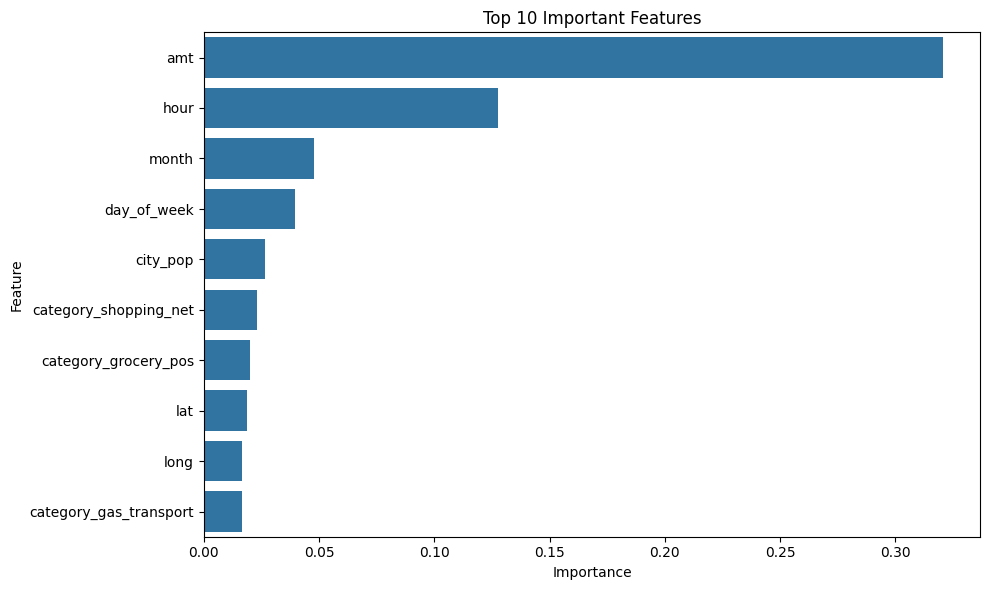


Confusion Matrix:


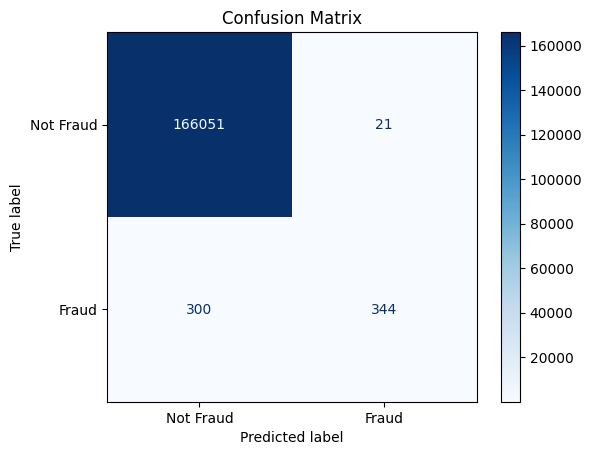


Fraudulent Transactions Detected:
            amt        category  distance  hour
1044     981.92    shopping_net  0.924359    18
1685      24.84  health_fitness  0.728964    22
1767     780.52        misc_net  0.801803    22
1781     620.33   entertainment  0.290285    22
1784    1077.69    shopping_net  0.983612    22
...         ...             ...       ...   ...
517197  1041.51    shopping_pos  0.064122    22
517274   868.09    shopping_pos  0.740201    22
517341  1039.42    shopping_net  0.399299    22
517529   289.27     grocery_pos  0.527994    23
517571   766.38        misc_net  1.152196    23

[1866 rows x 4 columns]

Fraudulent transactions saved to 'fraudulent_transactions.csv'

Top 10 Merchants with Most Fraud Transactions:
merchant
fraud_Romaguera, Cruickshank and Greenholt    18
fraud_Lemke-Gutmann                           18
fraud_Mosciski, Ziemann and Farrell           18
fraud_Schultz, Simonis and Little             17
fraud_Heathcote, Yost and Kertzmann           1

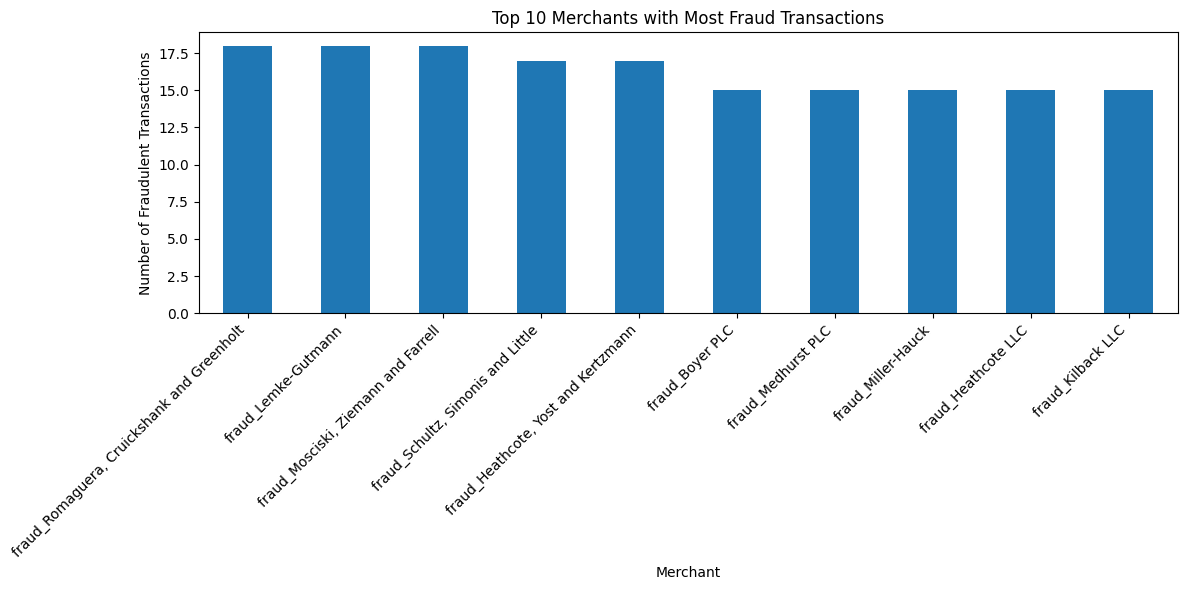


Fraud Distribution by Category:
category
grocery_pos       481
shopping_net      468
misc_net          245
shopping_pos      179
gas_transport     115
misc_pos           54
personal_care      52
kids_pets          47
entertainment      42
home               42
health_fitness     41
food_dining        38
grocery_net        32
travel             30
Name: count, dtype: int64


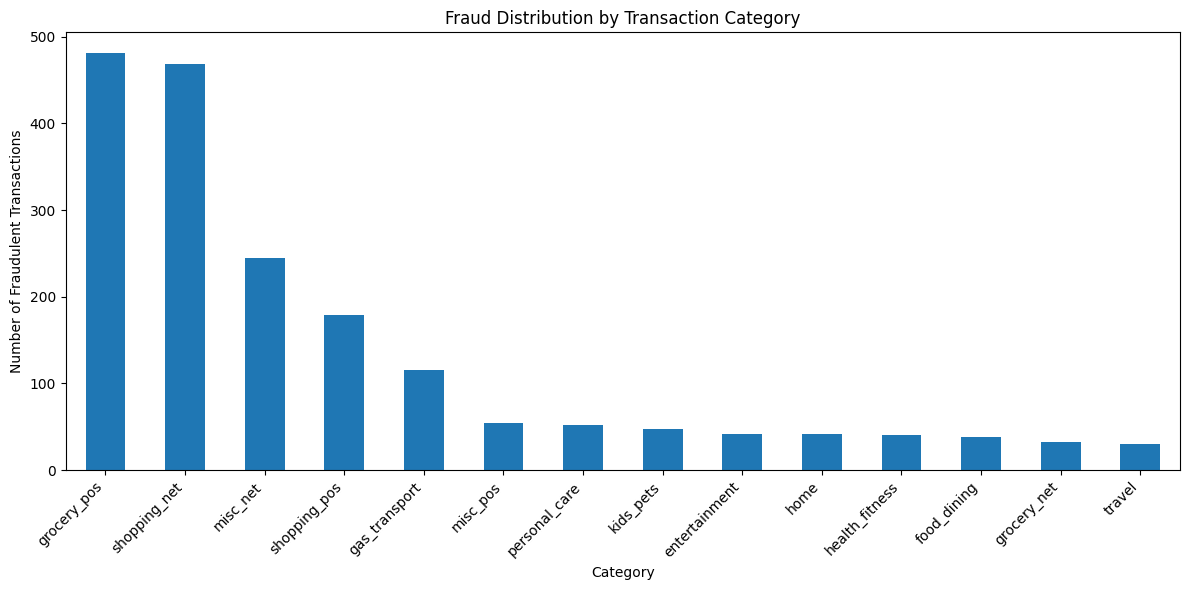

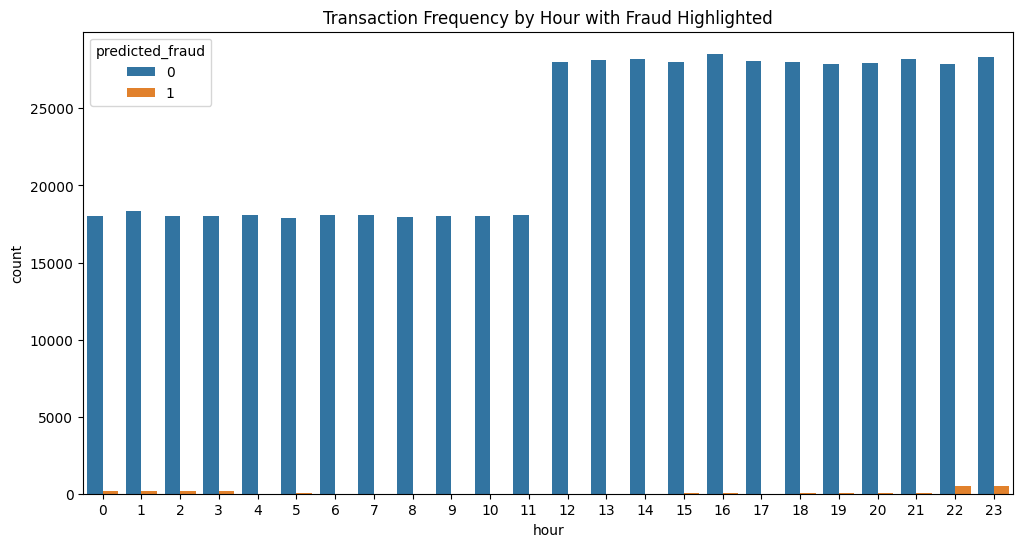

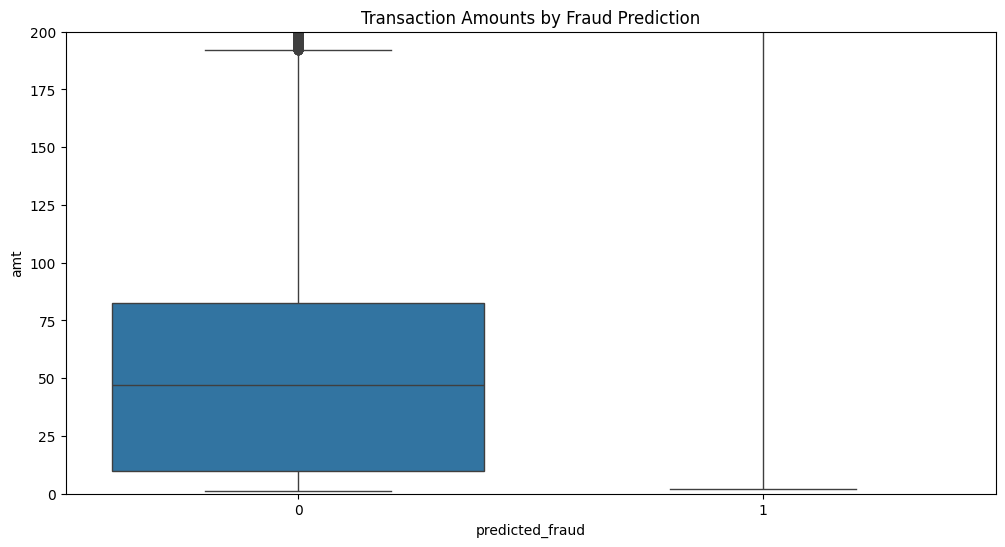

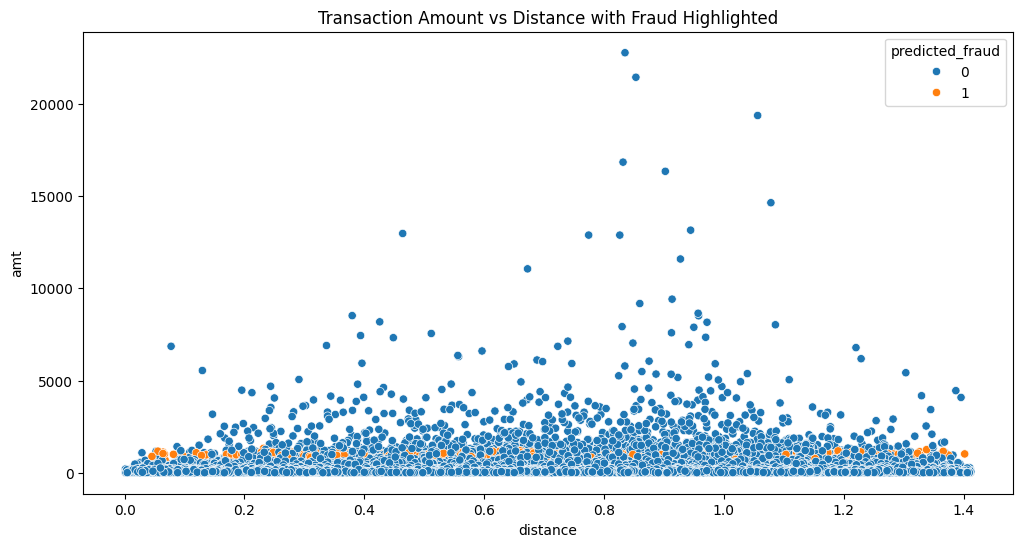

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv('Dataset.csv')

# Data Exploration
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nClass Distribution:")
print(df['is_fraud'].value_counts())

# Data Preprocessing
# Convert transaction date/time to datetime object
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], dayfirst=True)

# Extract useful time features
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['month'] = df['trans_date_trans_time'].dt.month

# Calculate distance between merchant and customer
df['distance'] = np.sqrt((df['merch_lat'] - df['lat'])**2 + (df['merch_long'] - df['long'])**2)

# Save merchant names before dropping
merchant_data = df[['merchant', 'is_fraud']].copy()

# Drop unnecessary columns
columns_to_drop = ['trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 
                   'zip', 'job', 'dob', 'trans_num', 'unix_time', 'cc_num', 'S. no']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Separate features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Define numerical and categorical features
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'distance', 'hour', 'day_of_week', 'month']
categorical_features = ['category', 'gender', 'merchant']  # Include merchant as categorical

# Ensure we only use columns that exist in the dataframe
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with SMOTE and Random Forest
model = imbpipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train model
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get feature names after one-hot encoding
feature_names = (numerical_features + 
                 list(model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features)))

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Predict on entire dataset
df['predicted_fraud'] = model.predict(X)

# Display fraudulent transactions
fraudulent_transactions = df[df['predicted_fraud'] == 1]
print("\nFraudulent Transactions Detected:")
print(fraudulent_transactions[['amt', 'category', 'distance', 'hour']])

# Save fraudulent transactions to CSV
fraudulent_transactions.to_csv('fraudulent_transactions.csv', index=False)
print("\nFraudulent transactions saved to 'fraudulent_transactions.csv'")

# Top 10 Merchants with Most Fraud Transactions
top_fraud_merchants = merchant_data[merchant_data['is_fraud'] == 1]['merchant'].value_counts().head(10)
print("\nTop 10 Merchants with Most Fraud Transactions:")
print(top_fraud_merchants)

plt.figure(figsize=(12, 6))
top_fraud_merchants.plot(kind='bar')
plt.title('Top 10 Merchants with Most Fraud Transactions')
plt.xlabel('Merchant')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Fraud by Category
fraud_by_category = df[df['predicted_fraud'] == 1]['category'].value_counts()
print("\nFraud Distribution by Category:")
print(fraud_by_category)

plt.figure(figsize=(12, 6))
fraud_by_category.plot(kind='bar')
plt.title('Fraud Distribution by Transaction Category')
plt.xlabel('Category')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualizations
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='predicted_fraud', data=df)
plt.title('Transaction Frequency by Hour with Fraud Highlighted')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='predicted_fraud', y='amt', data=df)
plt.ylim(0, 200)  # Limit y-axis to better visualize most transactions
plt.title('Transaction Amounts by Fraud Prediction')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='distance', y='amt', hue='predicted_fraud', data=df)
plt.title('Transaction Amount vs Distance with Fraud Highlighted')
plt.show()